In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import secretflow as sf

# Check the version of your SecretFlow
print('The version of SecretFlow: {}'.format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()

sf.init(['alice', 'bob', 'charlie'], address='local')
alice, bob, charlie = sf.PYU('alice'), sf.PYU('bob'), sf.PYU('charlie')

The version of SecretFlow: 1.8.0b0


/home/seallver/anaconda3/envs/sf/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-08-27 10:08:47,989	INFO worker.py:1724 -- Started a local Ray instance.


In [17]:
spu = sf.SPU(sf.utils.testing.cluster_def(['alice', 'bob']))

In [10]:
import pandas as pd
import pickle

df = pd.read_csv('data/1.csv')
data = df.to_dict(orient='list')

with open('data/data1.pkl', 'wb') as f:
    pickle.dump(data, f)

df = pd.read_csv('data/2.csv')
data = df.to_dict(orient='list')

with open('data/data2.pkl', 'wb') as f:
    pickle.dump(data, f)

alice.load("data/data1.pkl")
bob.load("data/data2.pkl")




In [11]:
import pandas as pd

alldata_df_1 = pd.read_csv("data/1.csv")
alldata_df_2 = pd.read_csv("data/2.csv")


h_alice_df = alldata_df_1.loc[:]
h_bob_df = alldata_df_2.loc[:]

import tempfile

_, h_alice_path = tempfile.mkstemp()
_, h_bob_path = tempfile.mkstemp()
h_alice_df.to_csv(h_alice_path, index=False)
h_bob_df.to_csv(h_bob_path, index=False)

from secretflow.data.horizontal import read_csv
from secretflow.security.aggregation.plain_aggregator import PlainAggregator
from secretflow.security.compare.plain_comparator import PlainComparator
from secretflow.data.split import train_test_split

path_dict = {alice: h_alice_path, bob: h_bob_path}

aggregator = PlainAggregator(charlie)
comparator = PlainComparator(charlie)

hdf = read_csv(filepath=path_dict, aggregator=aggregator, comparator=comparator)

label_x = hdf["x"]
data_x = hdf.drop(columns="x")

train_data_x, test_data_x = train_test_split(
    data_x, train_size=0.8, shuffle=True, random_state=1234
)

label_y = hdf["y"]
data_y = hdf.drop(columns="y")

train_data_y, test_data_y = train_test_split(
    data_y, train_size=0.8, shuffle=True, random_state=1234
)



print(train_data_x.partition_shape(), test_data_x.partition_shape())
print(train_data_y.partition_shape(), test_data_y.partition_shape())


INFO:root:Create proxy actor <class 'secretflow.device.proxy.ActorPartitionAgent'> with party alice.


INFO:root:Create proxy actor <class 'secretflow.device.proxy.ActorPartitionAgent'> with party bob.


270
{PYURuntime(alice): (104, 1), PYURuntime(bob): (112, 1)} {PYURuntime(alice): (27, 1), PYURuntime(bob): (28, 1)}
{PYURuntime(alice): (104, 1), PYURuntime(bob): (112, 1)} {PYURuntime(alice): (27, 1), PYURuntime(bob): (28, 1)}


In [12]:
def create_regression_model(input_shape, name='model'):
    def create_model():
        from tensorflow import keras
        from tensorflow.keras import layers

        model = keras.Sequential(
            [
                keras.Input(shape=input_shape),  # 输入年龄特征
                layers.Dense(64, activation="relu"),  # 隐藏层
                layers.Dense(64, activation="relu"),  # 可以添加更多隐藏层
                layers.Dense(64, activation="relu"),
                layers.Dense(64, activation="relu"),
                layers.Dense(1)  # 输出层，回归任务没有激活函数，输出一个连续值
            ]
        )
        model.compile(
            loss='mean_squared_error',  # 回归任务的损失函数
            optimizer='adam',  # 优化器
            metrics=['mae','mse']  # 额外的评价指标，例如平均绝对误差（MAE）
        )
        return model

    return create_model


INFO:root:Create proxy actor <class 'secretflow.device.proxy.Actor_Masker'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.device.proxy.Actor_Masker'> with party bob.
INFO:root:Create proxy actor <class 'secretflow.device.proxy.ActorPYUFedAvgW'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.device.proxy.ActorPYUFedAvgW'> with party bob.
INFO:root:FL Train Params: {'x': HDataFrame(partitions={PYURuntime(alice): <secretflow.data.core.partition.Partition object at 0x7f2a7462e650>, PYURuntime(bob): <secretflow.data.core.partition.Partition object at 0x7f29d86125f0>}, aggregator=<secretflow.security.aggregation.plain_aggregator.PlainAggregator object at 0x7f29d83ade10>, comparator=PlainComparator(device=PYURuntime(charlie))), 'y': HDataFrame(partitions={PYURuntime(alice): <secretflow.data.core.partition.Partition object at 0x7f2a7462fd00>, PYURuntime(bob): <secretflow.data.core.partition.Partition object at 0x7f29d86120e0>}, aggregator=<secretflow.secu

Epoch 1/10


Train Processing: :  18%|█▊        | 2/11 [00:00<00:00, 17.79it/s]

Epoch 2/10


Train Processing: :   9%|▉         | 1/11 [00:00<00:01,  7.12it/s]

Epoch 3/10


Train Processing: :  18%|█▊        | 2/11 [00:00<00:00, 19.24it/s]

Epoch 4/10


Train Processing: :  18%|█▊        | 2/11 [00:00<00:00, 16.92it/s]

Epoch 5/10


Train Processing: :  27%|██▋       | 3/11 [00:00<00:00, 25.90it/s]

Epoch 6/10


Train Processing: :  27%|██▋       | 3/11 [00:00<00:00, 25.65it/s]

Epoch 7/10


Train Processing: :  27%|██▋       | 3/11 [00:00<00:00, 23.19it/s]

Epoch 8/10


Train Processing: :  27%|██▋       | 3/11 [00:00<00:00, 24.77it/s]

Epoch 9/10


Train Processing: :  27%|██▋       | 3/11 [00:00<00:00, 25.04it/s]

Epoch 10/10


Train Processing: :  91%|█████████ | 10/11 [00:00<00:00, 10.86it/s, {'loss': 163.16193, 'mae': 10.141021, 'mse': 163.16193, 'val_loss': 157.7157, 'val_mae': 10.182222, 'val_mse': 157.7157}]


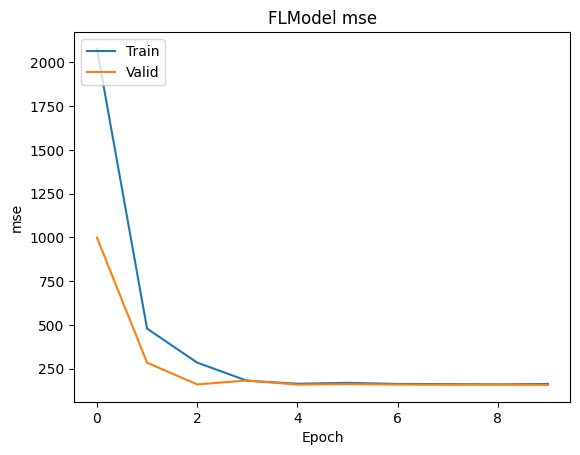

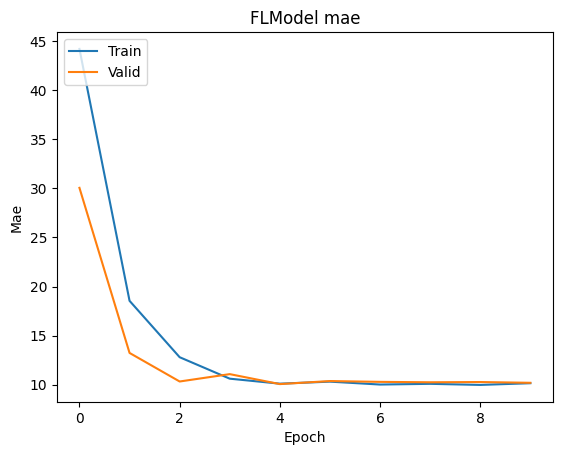

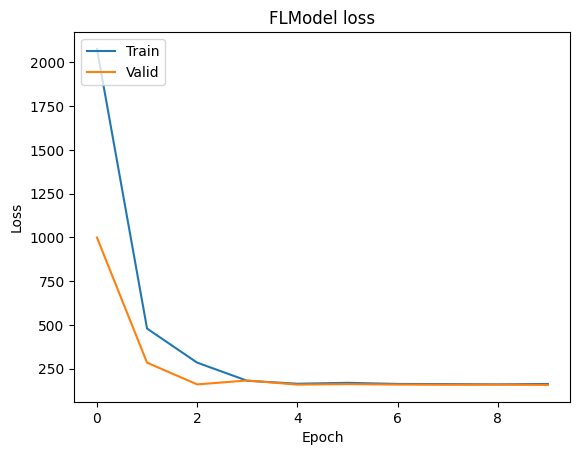

([Mean(name='val_loss', total=8674.363, count=55.0), Mean(name='val_mae', total=560.0223, count=55.0), Mean(name='val_mse', total=8674.363, count=55.0)], {'alice': [Mean(name='val_loss', total=3441.796, count=27.0), Mean(name='val_mae', total=255.43327, count=27.0), Mean(name='val_mse', total=3441.796, count=27.0)], 'bob': [Mean(name='val_loss', total=5232.5674, count=28.0), Mean(name='val_mae', total=304.589, count=28.0), Mean(name='val_mse', total=5232.5674, count=28.0)]})


In [20]:
from secretflow.security.aggregation import SecureAggregator
from secretflow.ml.nn import FLModel

input_shape = (1,)
model = create_regression_model(input_shape)

device_list = [alice, bob]

secure_aggregator = SecureAggregator(charlie, [alice, bob])


fed_model = FLModel(
    server=charlie,
    device_list=device_list,
    model=model,
    aggregator=secure_aggregator,
    strategy="fed_avg_w",
    backend="tensorflow",
)

history = fed_model.fit(
    train_data_x,
    train_data_y,
    validation_data=(test_data_x, test_data_y),
    epochs=10,
    sampler_method="batch",
    batch_size=10,
    aggregate_freq=1,
)

from matplotlib import pyplot as plt

# Draw mse values for training & validation
plt.plot(history["global_history"]['mse'])
plt.plot(history["global_history"]['val_mse'])
plt.title('FLModel mse')
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()


# Draw mae for training & validation
plt.plot(history["global_history"]['mae'])
plt.plot(history["global_history"]['val_mae'])
plt.title('FLModel mae')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()


# Draw loss for training & validation
plt.plot(history["global_history"]['loss'])
plt.plot(history["global_history"]['val_loss'])
plt.title('FLModel loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

global_metric = fed_model.evaluate(test_data_x, test_data_y, batch_size=20)
print(global_metric)